In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Effect of regularization

In [3]:
from sklearn.datasets import fetch_california_housing

data,target = fetch_california_housing(as_frame=True, return_X_y=True)
target*=100

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
cv_results = cross_validate(linear_regression, data, target, cv=10, scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

In [6]:
cv_results = pd.DataFrame(cv_results)

In [21]:
cv_results.head(5)
test_cv = -cv_results['test_score'].sort_values(ascending=False).reset_index(drop=True)
train_cv = -cv_results['train_score'].sort_values(ascending=False).reset_index(drop=True)

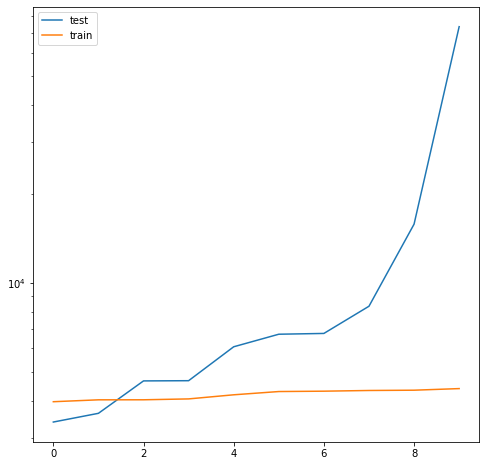

In [24]:
plt.figure(figsize=(8,8))
plt.plot(test_cv, label = 'test')
plt.plot(train_cv , label = 'train' )
plt.yscale('log')
plt.legend()

### This generalization performance gap between the training and testing score is an indication that our model overfitted our training set

In [29]:
model_first_fold = cv_results['estimator'][0]
feature_names = model_first_fold[0].get_feature_names_out(input_features=data.columns)

45

In [31]:
coefs = [model[-1].coef_ for model in cv_results['estimator']]
weights_linear_regression = pd.DataFrame(coefs,columns=feature_names)

<AxesSubplot:>

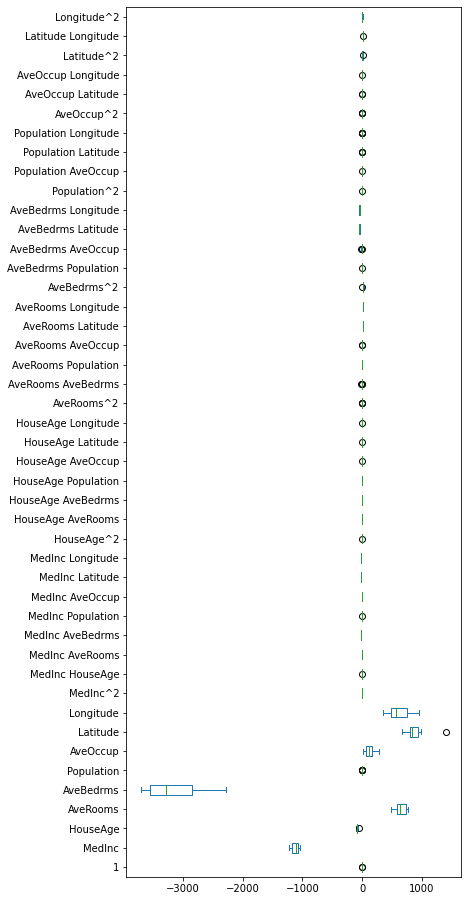

In [37]:
weights_linear_regression.plot.box(vert=False, figsize=(6,16))

### Regularization
box plot을 보면 AveBedrms이나 Latitude같이 weight이 엄청나게 크다보니 다른 값들이 그다지 영향력을 발휘하지 못한다는 것을 알 수 있다. Regularization은 이러한 값을 0으로 만들어서 다른 값이 골고루 영향을 줄 수 있도록 하는 방법이다.

In [39]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=100))

cv_results = cross_validate(ridge,data,target, cv=10, scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)

C:\Users\679oo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\679oo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67257e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\679oo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75536e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\679oo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67367e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\679oo\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgW

원래 이런 오류가 뜬다고 한다. 매우 큰값이나 매우 작은값이 들어가면 이렇게 오류가 뜬다고한다. 

<AxesSubplot:>

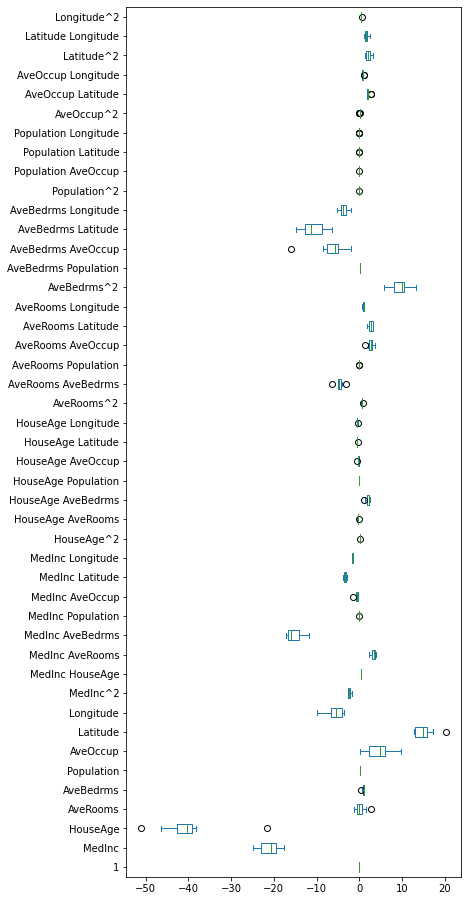

In [48]:
coefs = [model[-1].coef_ for model in cv_results['estimator']]
weights_ridge = pd.DataFrame(coefs,columns=feature_names)

weights_ridge.plot.box( vert=False, figsize=(6,16))

Ridge_regression을 사용하니 LinearRegression을 사용하는 것 보다 값들이 0에 가까워졌음을 확인할 수 있다.

### Feature scaling and regularization

Scaling도 weight을 결정할 때 매우 중요한 요소임.

Regularization은 scale이 작은 class를 부스팅하고 큰 calss를 감소시킨다. 결과적으로 weights를 서로 가깝게 만든다.

### When working with a linear model and numerical data, it is generally good practice to scale the data

In [49]:
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(), StandardScaler(), Ridge(alpha=0.5))
cv_results=cross_validate(ridge,data,target, cv=10, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)

In [51]:
print(f"Train_mean : {-cv_results['train_score'].mean()}, test_mean :{-cv_results['test_score'].mean()}")

Train_mean : 4347.036270227011, test_mean :5508.472404145571


We observe that scaling has a positive impact on the test score and that the test score is closer to the train score.

<AxesSubplot:>

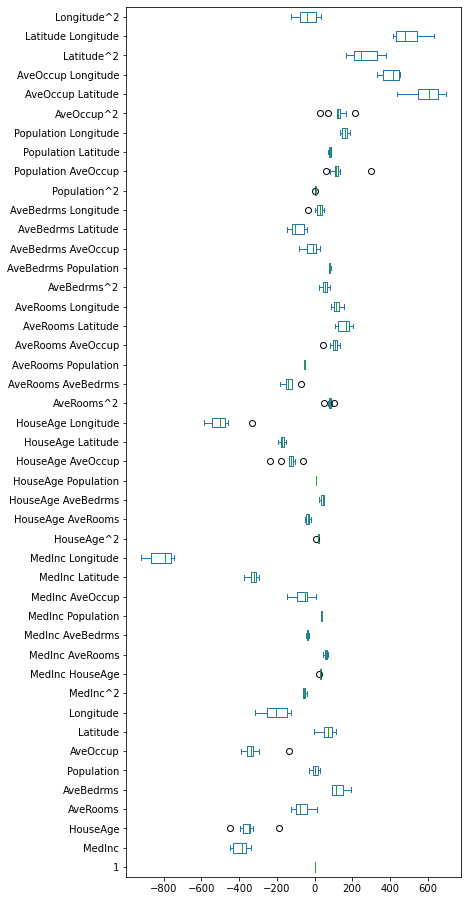

In [52]:
coefs = [model[-1].coef_ for model in cv_results['estimator']]
weights_ridge = pd.DataFrame(coefs,columns=feature_names)

weights_ridge.plot.box( vert=False, figsize=(6,16))

### alpha = 0.5 => alpha = 1_000_000

Train_mean : 12020.649993430929, test_mean :12543.889892473617


<AxesSubplot:>

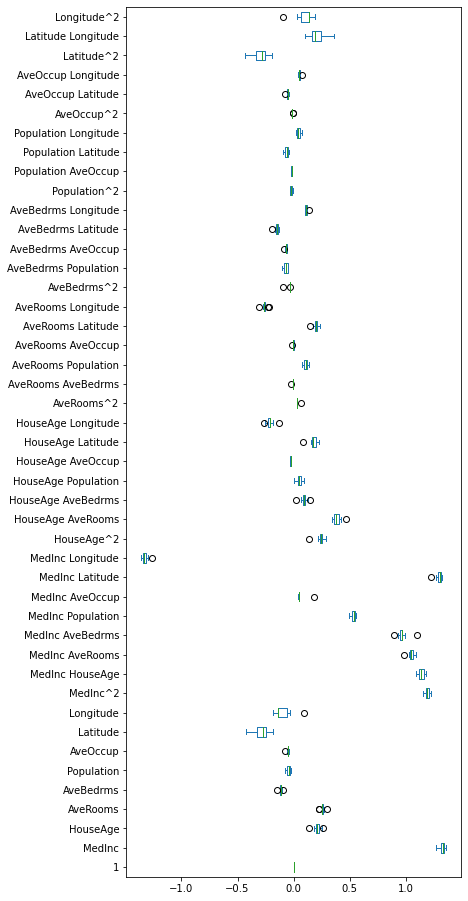

In [55]:
ridge = make_pipeline(PolynomialFeatures(), StandardScaler(), Ridge(alpha=1_000_000))
cv_results=cross_validate(ridge,data,target, cv=10, scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True)

print(f"Train_mean : {-cv_results['train_score'].mean()}, test_mean :{-cv_results['test_score'].mean()}")

coefs = [model[-1].coef_ for model in cv_results['estimator']]
weights_ridge = pd.DataFrame(coefs,columns=feature_names)

weights_ridge.plot.box(vert=False, figsize=(6,16))

alpha = 1_000_000결과 score은 좋지 않지만 weight이 -2 ~ 2 사이로 수렴하도록 했다.

### 주의할점
Categorical feature을 Onehotencoder로 encoding한 경우 scaling을 해서는 안된다. 

### Fine tuning the regularization parameter

최적의 parameter를 찾기 위해서는 train_set과 testing_set, out_of_sample testing set을 갖춰야한다.

Out_of_sample testing set은 train_set과 testing_set을 통해서 최적의 모델을 찾고난 다음 모델의 성능을 확인할때 쓰는 데이터이다.

Testing_set은 최적의 hyperparameter를 찾기 위해 사용되는 데이터로서, train_set에서 훈련받은 모델을 testing_set을 통해 alpha 값을 조정하는 과정을 거친다.



### 꿀팁
* 모델별로 최적의 hyperparameter를 찾기 위한 method가 존재한다. 모두 모델 끝에 CV가 붙는다.
* inner_cross_validation은 hyperparameter를 찾기위해 사용되고 nested_cross_validation은 모델의 실제 성능을 테스트하는 용도이다.


In [57]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-2,0,num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(), RidgeCV(alphas=alphas, store_cv_values=True))

In [58]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results=cross_validate(ridge,data,target,cv=cv,scoring='neg_mean_squared_error', return_estimator=True, return_train_score=True, n_jobs=-1)

In [59]:
print(f"Train_mean : {-cv_results['train_score'].mean()}, test_mean :{-cv_results['test_score'].mean()}")

Train_mean : 4306.561862713922, test_mean :4348.656991192537


### We see that the training and testing scores are close. It indicates that our model is not overfitting.

In [61]:
mse_alphas = [est[-1].cv_values_.mean(axis=0) for est in cv_results['estimator']]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,7587.897141,7059.531216,6579.796667,6161.839629,5813.048345,5535.350138,5326.646369,5182.950517,5100.749049,5079.212663,5122.029454,5238.704149,5445.118890,5763.012259,6217.925433,6835.274126,7634.692137,8623.620241,9791.918443,11109.476019
1,7079.341771,6696.622046,6329.022308,5987.727181,5681.306000,5415.171818,5191.880969,5012.209177,4876.780585,4787.974274,4751.851652,4779.853646,4889.937328,5106.656625,5459.549144,5979.280717,6691.530974,7609.581815,8727.609953,10017.092899
2,24857.406605,21448.284772,18293.478416,15481.009011,13067.031991,11071.457116,9480.437579,8254.431555,7338.963939,6675.026438,6207.024331,5887.541169,5679.263698,5554.913823,5496.051755,5491.367683,5534.775517,5623.398006,5755.456140,5928.154410
3,7504.216958,7125.074257,6754.172985,6400.999897,6072.937966,5774.941819,5509.955509,5280.027720,5087.960263,4939.271829,4844.228092,4819.618117,4889.808854,5086.420585,5445.877349,6004.320850,6790.113763,7815.311733,9068.542918,10511.939341
4,6999.938808,6598.898743,6215.363499,5861.328579,5546.025773,5275.377052,5052.349007,4878.140850,4753.964890,4683.117084,4673.049960,4737.162496,4895.935124,5176.863333,5612.500529,6236.037942,7074.449338,8140.303978,9424.471281,10892.352852


In [92]:
#### Cross validation 첫번째 Ridge Regression
cv_results['estimator'][0][-1]

# ### 뭔지 모르겠는제 뭐가 18000개 리스트가있는거지
# cv_results['estimator'][0][-1].cv_values_

# #### 흠... 뭘까...
# cv_results['estimator'][0][-1].cv_values_[0]

RidgeCV(alphas=array([0.01      , 0.01274275, 0.01623777, 0.02069138, 0.02636651,
       0.03359818, 0.04281332, 0.05455595, 0.06951928, 0.08858668,
       0.11288379, 0.14384499, 0.18329807, 0.23357215, 0.29763514,
       0.37926902, 0.48329302, 0.61584821, 0.78475997, 1.        ]),
        store_cv_values=True)

<AxesSubplot:>

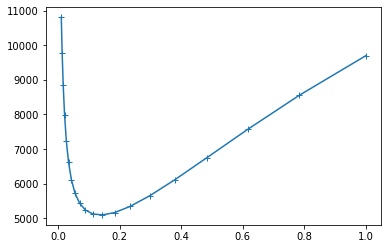

In [87]:
cv_alphas.mean(axis=0).plot(marker='+')

### Regularization is just like salt in cooking:

In [88]:
best_alphas = [est[-1].alpha_ for est in cv_results['estimator']]
best_alphas

### 매번 Cross validation 했을 때 결과 

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]